# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

## Precautions

#### change all hyperparameters and optimizers manually!!!

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

import platform
import time

import csv

import pickle

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 100
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


In [3]:
#early stop parameter

early_stopping_patience = 7  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a high value
early_stopping_counter = 0  # Counter to track the number of epochs without improvement

### Device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
# torch.cuda.empty_cache()
torch.cuda.is_available()

True


### Dataset


In [5]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
model = ConvNet()
model.to(device)

# Optionally, you can save the model's initial state_dict for later use
initial_state_dict = model.state_dict()

### Optimizer

In [8]:
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.NAdam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [9]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.CrossEntropyLoss()
###############################################################

In [10]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [11]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

### Model Training

SGD learning rate: 1e-1

In [12]:
data_list2 = []

In [13]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

T1 = time.perf_counter() 
for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.5f} Acc: {epoch_acc:.5f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
#     scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        
        data_point = {"Loss": val_loss, "Acc": val_acc}
        data_list2.append(data_point)
        
        print(f'Test Loss: {val_loss:.5f} Acc: {val_acc:.5f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
#         #early stop patience 5
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             early_stopping_counter = 0  # Reset the counter if there's an improvement
#         else:
#             early_stopping_counter += 1

#         if early_stopping_counter >= early_stopping_patience:
#             print("Early stopping. No improvement for {} epochs.".format(early_stopping_patience))
#             break  # Exit the training loop

T2= time.perf_counter() 

print(f'train_time:{T2-T1:.4f}')

Epoch: 1/100 Train Loss: 0.01592 Acc: 0.25322
Begin test......
Test Loss: 0.01424 Acc: 0.35230
Epoch: 2/100 Train Loss: 0.01360 Acc: 0.36420
Begin test......
Test Loss: 0.01214 Acc: 0.43700
Epoch: 3/100 Train Loss: 0.01273 Acc: 0.40902
Begin test......
Test Loss: 0.01143 Acc: 0.47880
Epoch: 4/100 Train Loss: 0.01228 Acc: 0.42946
Begin test......
Test Loss: 0.01098 Acc: 0.49990
Epoch: 5/100 Train Loss: 0.01199 Acc: 0.44644
Begin test......
Test Loss: 0.01106 Acc: 0.50490
Epoch: 6/100 Train Loss: 0.01174 Acc: 0.45740
Begin test......
Test Loss: 0.01051 Acc: 0.51870
Epoch: 7/100 Train Loss: 0.01148 Acc: 0.47392
Begin test......
Test Loss: 0.01103 Acc: 0.49720
Epoch: 8/100 Train Loss: 0.01130 Acc: 0.48284
Begin test......
Test Loss: 0.01041 Acc: 0.52420
Epoch: 9/100 Train Loss: 0.01124 Acc: 0.48722
Begin test......
Test Loss: 0.01044 Acc: 0.52380
Epoch: 10/100 Train Loss: 0.01107 Acc: 0.49064
Begin test......
Test Loss: 0.01051 Acc: 0.52200
Epoch: 11/100 Train Loss: 0.01101 Acc: 0.49268
Be

In [14]:
# Save data_list1 to a file
with open('SGD_nomomentum100.pkl', 'wb') as file:
    pickle.dump(data_list2, file)

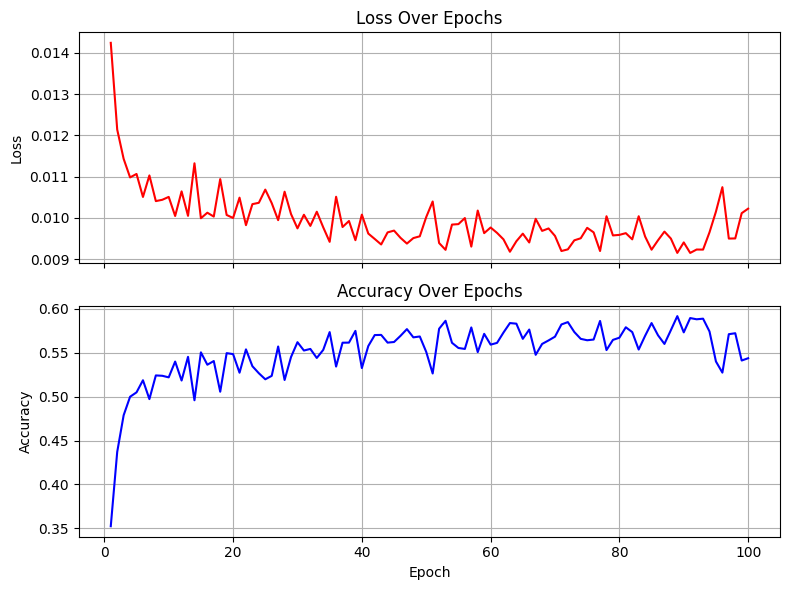

In [15]:
# Your 2D array
data = data_list2

# Extract Loss and Acc values, and move tensors to CPU
loss_values = [point['Loss'] for point in data_list2]
acc_values = [point['Acc'].cpu().item() for point in data_list2]

# Create a list of x-axis labels (epochs)
epochs = list(range(1, len(loss_values) + 1))

# Create separate subplots for Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot Loss
ax1.plot(epochs, loss_values, label='Loss', color='red')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plot Accuracy
ax2.plot(epochs, acc_values, label='Accuracy', color='blue')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

# Add titles
ax1.set_title('Loss Over Epochs')
ax2.set_title('Accuracy Over Epochs')

# Display the plot
plt.tight_layout()
plt.show()

# plot 3

### change the files manually

In [ ]:
# Function to load data from a pickled file
def load_data(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

# Load data from the three pickled files
data_list_1e1 = load_data('SGD_nomomentum1.pkl')
data_list_1e2 = load_data('SGD_nomomentum2.pkl')
data_list_1e3 = load_data('SGD_nomomentum3.pkl')

# Create subplots for Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot Loss for each learning rate
ax1.plot(range(1, len(data_list_1e1) + 1), [point['Loss'] for point in data_list_1e1], label='1e-1', linestyle='-')
ax1.plot(range(1, len(data_list_1e2) + 1), [point['Loss'] for point in data_list_1e2], label='1e-2', linestyle='-')
ax1.plot(range(1, len(data_list_1e3) + 1), [point['Loss'] for point in data_list_1e3], label='1e-3', linestyle='-')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plot Accuracy for each learning rate
ax2.plot(range(1, len(data_list_1e1) + 1), [float(str(point['Acc']).split('tensor(')[-1].split(',')[0]) for point in data_list_1e1], label='1e-1', linestyle='-')
ax2.plot(range(1, len(data_list_1e2) + 1), [float(str(point['Acc']).split('tensor(')[-1].split(',')[0]) for point in data_list_1e2], label='1e-2', linestyle='-')
ax2.plot(range(1, len(data_list_1e3) + 1), [float(str(point['Acc']).split('tensor(')[-1].split(',')[0]) for point in data_list_1e3], label='1e-3', linestyle='-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

# Add titles and legends
ax1.set_title('Loss Over Epochs')
ax2.set_title('Accuracy Over Epochs')
ax1.legend(title='Learning Rate')

# Display the plot
plt.tight_layout()
plt.savefig('SGD_nomomentum.png')
plt.show()